# Practical session 1
>  - María Castro
>  - Jorge Martín
>  - Miguel Angel Rojas


## Import library

In [159]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas_profiling
from datetime import datetime
import pickle


## Functions

In [151]:
def read(file_name, fheader, fletter, ftrial):
   # global fdata2
    fsadl1 = pd.read_csv(file_name, sep=';', decimal=',', names=fheader)
   
    fsadl1['muestra'] = fletter
    #fsadl1['trial'] = ftrial
    fdata = fsadl1[['fecha','MILLISEC','muestra','mano_der_pulgar_nud_x','mano_der_pulgar_nud_y',
'mano_der_pulgar_nud_z',
'mano_der_pulgar_fal1_x',
'mano_der_pulgar_fal1_y',
'mano_der_pulgar_fal1_z',
'mano_der_pulgar_punta_x',
'mano_der_pulgar_punta_y',
'mano_der_pulgar_punta_z',
'mano_der_indice_fal2_x',
'mano_der_indice_fal2_y',
'mano_der_indice_fal2_z',
'mano_der_indice_fal1_x',
'mano_der_indice_fal1_y',
'mano_der_indice_fal1_z',
'mano_der_indice_punta_x',
'mano_der_indice_punta_y',
'mano_der_indice_punta_z',
'mano_der_corazon_fal2_x',
'mano_der_corazon_fal2_y',
'mano_der_corazon_fal2_z',
'mano_der_corazon_fal1_x',
'mano_der_corazon_fal1_y',
'mano_der_corazon_fal1_z',
'mano_der_corazon_punta_x',
'mano_der_corazon_punta_y',
'mano_der_corazon_punta_z',
'mano_der_aular_fal2_x',
'mano_der_aular_fal2_y',
'mano_der_aular_fal2_z',
'mano_der_aular_fal1_x',
'mano_der_aular_fal1_y',
'mano_der_aular_fal1_z',
'mano_der_aular_punta_x',
'mano_der_aular_punta_y',
'mano_der_aular_punta_z',
'mano_der_menique_fal2_x',
'mano_der_menique_fal2_y',
'mano_der_menique_fal2_z',
'mano_der_menique_fal1_x',
'mano_der_menique_fal1_y',
'mano_der_menique_fal1_z',
'mano_der_menique_punta_x',
'mano_der_menique_punta_y',
'mano_der_menique_punta_z'] ]
    
    # Merge them
    
    
    flabels = fsadl1['muestra']
    ## Preprocessing data
    #find and remove rows with all nulls
    fidx=fdata.index[fdata.isnull().all(1)] #1 is the axis for rows
    #select data not in idx, that is data that is not all null
    fdata = fdata[~fdata.index.isin(fidx)] 
    #same for labels
    flabels = flabels[~flabels.index.isin(fidx)]

    flabels.value_counts()


    #fill missing values
    fdata = fdata.fillna(method='ffill',axis=1)
    
    return fdata, flabels


In [152]:
def num_to_letter(number):
    switcher = {
        1: "A",
        2: "C",
        3: "L",
        4: "M",
        5: "O",
        6: "U"
    }
    return switcher.get(number, "Invalid month")

In [153]:
#separate train and test train_test_split function' 
def train_test_split_local(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    train_test_split(y, shuffle=False)
    return X_train, X_test, y_train, y_test

In [154]:
def plot_confusion_matrix(cm, names, title='MATRIZ DE CONFUSIÓN', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')

In [155]:
def windowing(fdata, window_number, window_text, porcentage, flabels, frol):

    for ind in range(0,len(fdata.index)):
        resta= fdata.fecha[ind] - fdata.fecha[0]
        fdata.MILLISEC[ind] =  resta.total_seconds()*1000
    
    #print(fdata)
    columns = fdata.columns[~fdata.columns.isin(['muestra', 'fecha','MILLISEC'])]
    
    ffiltered_data = fdata[columns].rolling(frol).median()
    ffiltered_data['MILLISEC'] = fdata.MILLISEC    
    #print(ffiltered_data)
    #all_features_1S.dropna()
    #ffiltered_data.fillna(0)
    ffiltered_data.fillna(0, inplace=True)
    # Windowing and Feature Extraction
    ffiltered_data['time']=pd.to_datetime(fdata.MILLISEC,unit='ms')    
    ffiltered_data.index=ffiltered_data.time
    
    
    #calculate mean over a 1 second window
    keep = ffiltered_data.time.dt.microsecond/window_number %porcentage
    keep = keep - keep.shift() < 0

  
    ffiltered_data.sort_index()
    means = ffiltered_data[columns].rolling(window_text).mean()[keep]
    means.columns = [str(col) + '_mean' for col in means.columns]
    variances = ffiltered_data[columns].rolling(window_text).var()[keep]
    variances.columns = [str(col) + '_var' for col in variances.columns]

    #talk about apply function
    flabels.index = ffiltered_data.time
    mode_labels = flabels.rolling(window_text).apply(lambda x:mode(x)[0])[keep]

    #all features
    fall_features = pd.concat([means, variances],axis=1)
    fall_features['muestra'] = mode_labels
    #fall_features['user'] = user
    #fall_features['trial'] = trial
    
    return fall_features

## Execises definitions and clasifiers


In [229]:
def excercise_1 (fall_data, estimators):
    # Exercise 1
    # Random train test split

    # Labels are the values we want to predict
    labels = np.array(fall_data['muestra'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = fall_data.drop('muestra', axis = 1)
    #features = features.drop('fecha', axis = 1)
    #features = features.drop('time', axis = 1)


    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)


    X_train, X_test, y_train, y_test = train_test_split_local(features, labels)

    print('X_train:', X_train.shape)
    print('X_test:', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)


    classifier = RandomForestClassifier(n_estimators=estimators, random_state=0)  
    classifier.fit(X_train, y_train)  
    
    y_pred = classifier.predict(X_test)
    
    labels = ["A","C","L","M","O","U"]

    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test,y_pred))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test,y_pred))  
    print("_______________________________________________________")  
    print("accuracy score: " + str(accuracy_score(y_test, y_pred)))  

    
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test,y_pred), labels)

def excercise_2 (fall_data, test_data, estimators):
    # Exercise 1
    # Random train test split
    x_test = test_data.drop('muestra', axis = 1)
    y_test = np.array(test_data['muestra'])
    
    x_train = fall_data.drop('muestra', axis = 1)
    x_train = np.array(x_train)
    y_train = np.array(fall_data['muestra'])

    '''# Labels are the values we want to predict
    labels = np.array(fall_data['muestra'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = fall_data.drop('muestra', axis = 1)
    #features = features.drop('fecha', axis = 1)
    #features = features.drop('time', axis = 1)


    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)


    X_train, X_test, y_train, y_test = train_test_split_local(features, labels)'''

    print('X_train:', x_train.shape)
    print('X_test:', x_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)


    classifier = RandomForestClassifier(n_estimators=estimators, random_state=0)  
    classifier.fit(x_train, y_train)  
    
    y_pred = classifier.predict(x_test)
    
    labels = ["A","C","L","M","O","U"]

    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test,y_pred))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test,y_pred))  
    print("_______________________________________________________")  
    print("accuracy score: " + str(accuracy_score(y_test, y_pred)))  

    
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test,y_pred), labels)

## Read data

In [ ]:

path = 'dataset-proyecto/' #enter thepath for the dataset folder
header_path = 'header-proy.csv' #enter the path for the header file
header=pd.read_csv(header_path,names=['column',''],sep=';', decimal=',')['column'].values
num_letters = range(1,7) #7
trials = range(1,6) #6
users=range(2,6) #6


In [135]:
all_data_1S = pd.DataFrame()
data = pd.DataFrame()
all_features_1S = pd.DataFrame()

for num_letter in num_letters:
    letter = num_to_letter(num_letter)
    for user in users:
        for trial in trials:
            try:
                file_name = path+str(letter)+'-'+str(user)+'-'+str(trial)+'.csv'
                print(str(letter)+'-'+str(user)+'-'+str(trial)+'.csv')
                data, labels = read(file_name, header, num_letter, trial)
                data['fecha'] = pd.to_datetime(data['fecha'], format='%H.%M.%S.%f', errors='ignore')
            
                data.loc[:,'MILLISEC':] = data.loc[:,'MILLISEC':].apply(pd.to_numeric, errors='coerce')
            
                all_features_1S = windowing(data, 1000, '1S', 500, labels, 58)
            #all_features_1S.dropna()
            
                all_data_1S = pd.concat([all_data_1S, all_features_1S])
            except:
                print("Error cargando el archivo : "+ str(letter)+'-'+str(user)+'-'+str(trial)+'.csv')
            #all_data_1S.fillna()



A-2-1.csv


/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


A-2-2.csv
A-2-3.csv
A-2-4.csv
A-2-5.csv
A-3-1.csv
A-3-2.csv
A-3-3.csv
A-3-4.csv
A-3-5.csv
A-4-1.csv
A-4-2.csv
El archivo no existe: A-4-2.csv
A-4-3.csv


/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


El archivo no existe: A-4-3.csv
A-4-4.csv


/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


A-4-5.csv
A-5-1.csv
A-5-2.csv
A-5-3.csv
A-5-4.csv
A-5-5.csv
C-2-1.csv
C-2-2.csv
C-2-3.csv
C-2-4.csv
C-2-5.csv
C-3-1.csv
C-3-2.csv
C-3-3.csv
El archivo no existe: C-3-3.csv
C-3-4.csv
C-3-5.csv
C-4-1.csv
C-4-2.csv
C-4-3.csv
C-4-4.csv
C-4-5.csv
C-5-1.csv
C-5-2.csv
C-5-3.csv
C-5-4.csv
C-5-5.csv
L-2-1.csv
L-2-2.csv
L-2-3.csv
L-2-4.csv
L-2-5.csv
L-3-1.csv
L-3-2.csv
L-3-3.csv
L-3-4.csv
L-3-5.csv
El archivo no existe: L-3-5.csv
L-4-1.csv


/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


L-4-2.csv
L-4-3.csv
L-4-4.csv
L-4-5.csv
L-5-1.csv
L-5-2.csv
L-5-3.csv
L-5-4.csv
L-5-5.csv
M-2-1.csv
M-2-2.csv
M-2-3.csv
M-2-4.csv
M-2-5.csv
M-3-1.csv
M-3-2.csv
M-3-3.csv
M-3-4.csv
M-3-5.csv
M-4-1.csv
M-4-2.csv
M-4-3.csv
M-4-4.csv
M-4-5.csv
M-5-1.csv
M-5-2.csv
El archivo no existe: M-5-2.csv
M-5-3.csv


/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


M-5-4.csv
M-5-5.csv
O-2-1.csv
O-2-2.csv
O-2-3.csv
O-2-4.csv
O-2-5.csv
O-3-1.csv
O-3-2.csv
O-3-3.csv
O-3-4.csv
O-3-5.csv
O-4-1.csv
O-4-2.csv
O-4-3.csv
O-4-4.csv
O-4-5.csv
O-5-1.csv
O-5-2.csv
O-5-3.csv
O-5-4.csv
O-5-5.csv
U-2-1.csv
U-2-2.csv
U-2-3.csv
U-2-4.csv
U-2-5.csv
U-3-1.csv
U-3-2.csv
U-3-3.csv
U-3-4.csv
U-3-5.csv
U-4-1.csv
U-4-2.csv
U-4-3.csv
U-4-4.csv
U-4-5.csv
U-5-1.csv
U-5-2.csv
U-5-3.csv
U-5-4.csv
U-5-5.csv


In [ ]:
def dataaug():
    for num_letter_a in num_letters_a:
    letter_a = num_to_letter(num_letter_a)
    for user_a in users_a:
        for trial_a in trials_a:
            try:
                file_name = path+str(letter_a)+'-'+str(user_a)+'-'+str(trial_a)+'.csv'
                print(str(letter_a)+'-'+str(user_a)+'-'+str(trial_a)+'_aug.csv')
                data, labels = read(file_name, header, num_letter_a, trial_a)
                data['mano_izq_pulgar_nud_x'] = data.apply(lambda row: x*(-1), axis=1)
                data['fecha'] = pd.to_datetime(data['fecha'], format='%H.%M.%S.%f', errors='ignore')
            
                data.loc[:,'MILLISEC':] = data.loc[:,'MILLISEC':].apply(pd.to_numeric, errors='coerce')
            
                all_features_1S = windowing(data, 1000, '1S', 500, labels, 58)
            #all_features_1S.dropna()
            
                all_data_1S = pd.concat([all_data_1S, all_features_1S])
            except:
                print("Error cargando el archivo : "+ str(letter_a)+'-'+str(user_a)+'-'+str(trial_a)+'.csv')
            #all_data_1S.fillna()

In [157]:
all_data_1S


,mano_der_pulgar_nud_x_mean,mano_der_pulgar_nud_y_mean,mano_der_pulgar_nud_z_mean,mano_der_pulgar_fal1_x_mean,mano_der_pulgar_fal1_y_mean,mano_der_pulgar_fal1_z_mean,mano_der_pulgar_punta_x_mean,mano_der_pulgar_punta_y_mean,mano_der_pulgar_punta_z_mean,mano_der_indice_fal2_x_mean,...,mano_der_menique_fal2_x_var,mano_der_menique_fal2_y_var,mano_der_menique_fal2_z_var,mano_der_menique_fal1_x_var,mano_der_menique_fal1_y_var,mano_der_menique_fal1_z_var,mano_der_menique_punta_x_var,mano_der_menique_punta_y_var,mano_der_menique_punta_z_var,muestra
time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.510244,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
1970-01-01 00:00:01.009960,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
1970-01-01 00:00:01.509666,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
1970-01-01 00:00:02.010383,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
1970-01-01 00:00:02.520387,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
1970-01-01 00:00:03.010716,0.0,0.0,0.0,0.0,0.0,0.0,-0.000860,0.001645,0.000000,0.000144,...,2.436339e-07,2.967751e-05,1.182313e-05,8.135949e-05,2.822719e-05,6.164343e-05,1.812923e-04,2.106488e-05,9.175071e-06,1.0
1970-01-01 00:00:03.511909,0.0,0.0,0.0,0.0,0.0,0.0,-0.010999,0.021448,0.000169,0.001821,...,3.566411e-06,2.876273e-04,8.430953e-05,6.348946e-04,3.914462e-04,4.204092e-04,1.274075e-03,2.491679e-04,6.168107e-05,1.0
1970-01-01 00:00:04.011864,0.0,0.0,0.0,0.0,0.0,0.0,-0.020395,0.040706,0.001068,0.003155,...,1.641879e-06,2.516147e-06,2.722226e-07,4.625417e-06,1.185230e-05,9.496167e-07,1.512883e-07,2.851855e-06,1.628527e-06,1.0
1970-01-01 00:00:04.511342,0.0,0.0,0.0,0.0,0.0,0.0,-0.020365,0.040943,0.002532,0.002935,...,7.314436e-08,6.258891e-08,2.522320e-07,9.386160e-08,5.979042e-07,2.283039e-07,1.214755e-07,4.178494e-07,1.781594e-07,1.0


In [137]:
all_data_1S.dtypes

mano_der_pulgar_nud_x_mean       float64
mano_der_pulgar_nud_y_mean       float64
mano_der_pulgar_nud_z_mean       float64
mano_der_pulgar_fal1_x_mean      float64
mano_der_pulgar_fal1_y_mean      float64
mano_der_pulgar_fal1_z_mean      float64
mano_der_pulgar_punta_x_mean     float64
mano_der_pulgar_punta_y_mean     float64
mano_der_pulgar_punta_z_mean     float64
mano_der_indice_fal2_x_mean      float64
mano_der_indice_fal2_y_mean      float64
mano_der_indice_fal2_z_mean      float64
mano_der_indice_fal1_x_mean      float64
mano_der_indice_fal1_y_mean      float64
mano_der_indice_fal1_z_mean      float64
mano_der_indice_punta_x_mean     float64
mano_der_indice_punta_y_mean     float64
mano_der_indice_punta_z_mean     float64
mano_der_corazon_fal2_x_mean     float64
mano_der_corazon_fal2_y_mean     float64
mano_der_corazon_fal2_z_mean     float64
mano_der_corazon_fal1_x_mean     float64
mano_der_corazon_fal1_y_mean     float64
mano_der_corazon_fal1_z_mean     float64
mano_der_corazon

## Exploratory data analysis

In [138]:
all_data_1S.describe()

,mano_der_pulgar_nud_x_mean,mano_der_pulgar_nud_y_mean,mano_der_pulgar_nud_z_mean,mano_der_pulgar_fal1_x_mean,mano_der_pulgar_fal1_y_mean,mano_der_pulgar_fal1_z_mean,mano_der_pulgar_punta_x_mean,mano_der_pulgar_punta_y_mean,mano_der_pulgar_punta_z_mean,mano_der_indice_fal2_x_mean,...,mano_der_menique_fal2_x_var,mano_der_menique_fal2_y_var,mano_der_menique_fal2_z_var,mano_der_menique_fal1_x_var,mano_der_menique_fal1_y_var,mano_der_menique_fal1_z_var,mano_der_menique_punta_x_var,mano_der_menique_punta_y_var,mano_der_menique_punta_z_var,muestra
count,2524.0,2524.0,2524.0,2524.0,2524.0,2524.0,2524.000000,2524.000000,2524.000000,2524.000000,...,2.524000e+03,2.524000e+03,2.524000e+03,2.524000e+03,2.524000e+03,2.524000e+03,2.524000e+03,2.524000e+03,2.524000e+03,2524.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,-0.016665,0.011245,-0.003474,0.001156,...,8.107275e-06,5.942179e-06,1.065094e-05,3.342127e-05,2.725177e-05,3.124710e-05,5.601155e-05,3.681649e-05,3.635919e-05,3.575674
std,0.0,0.0,0.0,0.0,0.0,0.0,0.021697,0.017319,0.010523,0.006642,...,3.846131e-05,3.312448e-05,4.521532e-05,1.505637e-04,1.164431e-04,1.333402e-04,2.332945e-04,1.586475e-04,1.691913e-04,1.706408
min,0.0,0.0,0.0,0.0,0.0,0.0,-0.045124,-0.025188,-0.038421,-0.013980,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,-0.036964,-0.000550,-0.011141,-0.004217,...,5.940192e-10,6.080927e-10,9.389152e-10,1.611121e-09,2.709129e-09,5.116533e-09,2.940581e-09,5.011355e-09,7.499914e-09,2.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,-0.024221,0.005843,-0.000099,0.000000,...,7.939686e-09,1.155700e-08,1.190318e-08,2.421326e-08,3.798912e-08,6.217711e-08,3.183035e-08,6.132909e-08,8.484731e-08,4.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028054,0.001927,0.005353,...,6.819372e-08,1.219720e-07,1.060288e-07,2.285807e-07,3.517200e-07,4.945944e-07,3.287442e-07,5.682695e-07,7.029442e-07,5.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.036207,0.040943,0.026795,0.017560,...,3.823857e-04,5.997509e-04,4.140262e-04,1.412664e-03,1.817055e-03,1.372439e-03,2.388142e-03,2.360366e-03,1.769929e-03,6.000000


In [17]:
%matplotlib inline

In [139]:
all_data_1S.head()

,mano_der_pulgar_nud_x_mean,mano_der_pulgar_nud_y_mean,mano_der_pulgar_nud_z_mean,mano_der_pulgar_fal1_x_mean,mano_der_pulgar_fal1_y_mean,mano_der_pulgar_fal1_z_mean,mano_der_pulgar_punta_x_mean,mano_der_pulgar_punta_y_mean,mano_der_pulgar_punta_z_mean,mano_der_indice_fal2_x_mean,...,mano_der_menique_fal2_x_var,mano_der_menique_fal2_y_var,mano_der_menique_fal2_z_var,mano_der_menique_fal1_x_var,mano_der_menique_fal1_y_var,mano_der_menique_fal1_z_var,mano_der_menique_punta_x_var,mano_der_menique_punta_y_var,mano_der_menique_punta_z_var,muestra
time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.510244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1970-01-01 00:00:01.009960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1970-01-01 00:00:01.509666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1970-01-01 00:00:02.010383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1970-01-01 00:00:02.520387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [140]:
pandas_profiling.ProfileReport(all_data_1S)

/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Number of variables,92
Number of observations,2524
Total Missing (%),0.0%
Total size in memory,1.8 MiB
Average record size in memory,736.0 B
Numeric,36
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,55


## Metrics

############# 10 estimator ################
X_train: (1691, 90)
X_test: (833, 90)
y_train: (1691,)
y_test: (833,)

 _______________________________________________________
confusion matrix: 

[[110   0  20   0   0   0]
 [  0  99  22   0   3   1]
 [  1   0 148   0   0   3]
 [  0   0  25 121   1   0]
 [  0   4  17   0 106   0]
 [  0   1  22   0   0 129]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

         1.0       0.99      0.85      0.91       130
         2.0       0.95      0.79      0.86       125
         3.0       0.58      0.97      0.73       152
         4.0       1.00      0.82      0.90       147
         5.0       0.96      0.83      0.89       127
         6.0       0.97      0.85      0.91       152

   micro avg       0.86      0.86      0.86       833
   macro avg       0.91      0.85      0.87       833
weighted avg       0.90      0.86      0.87       833

___________________

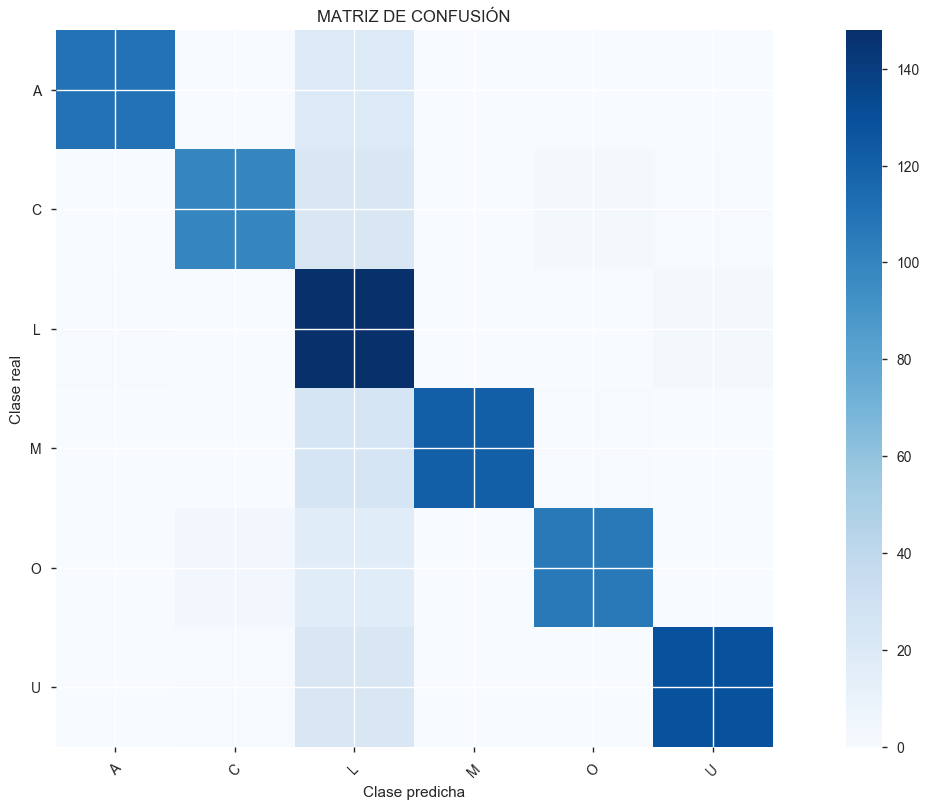

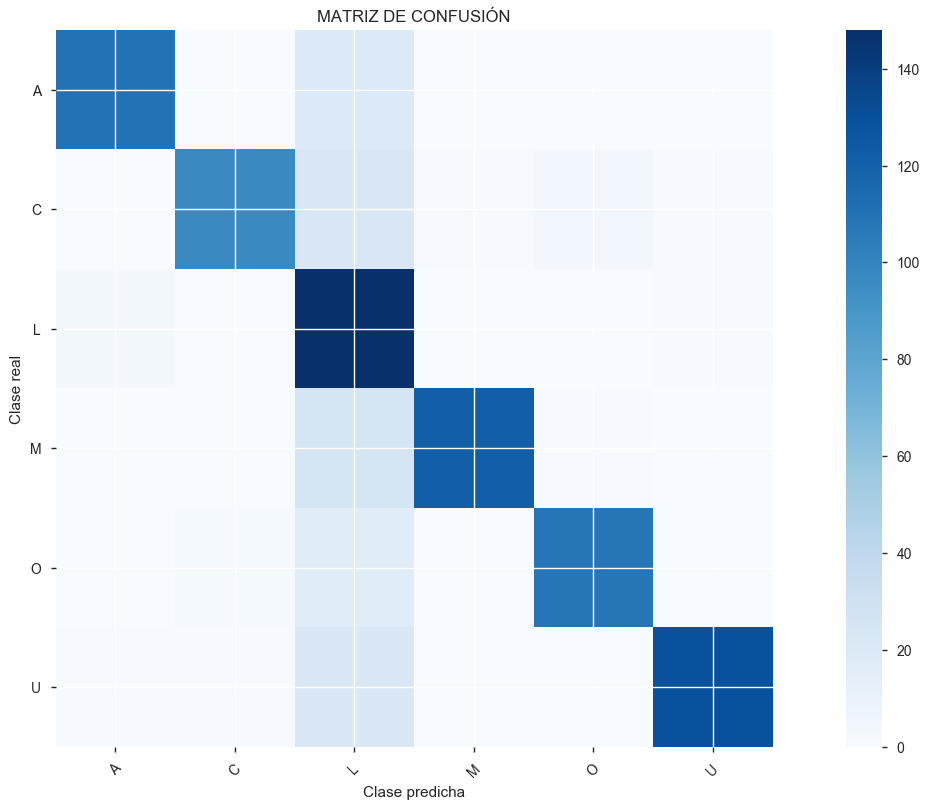

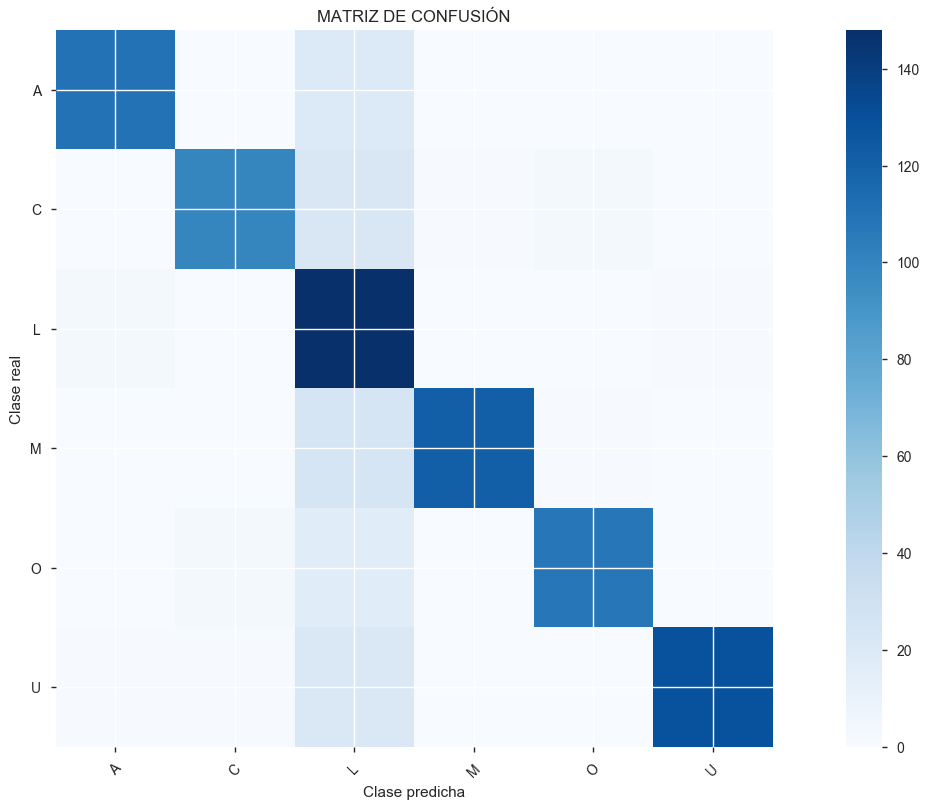

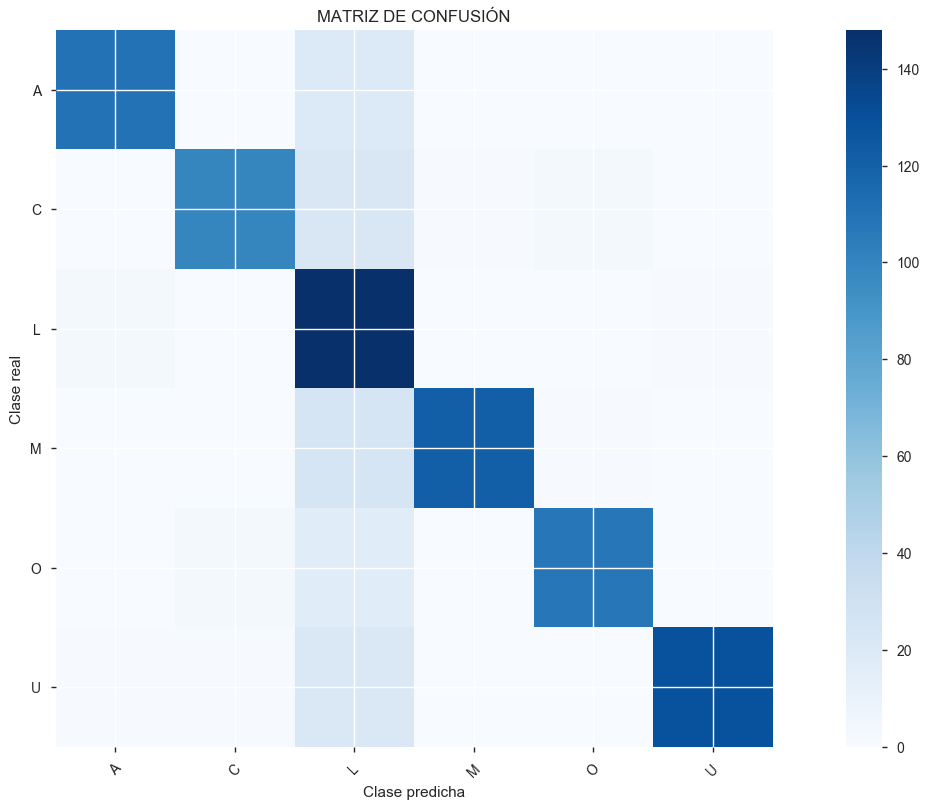

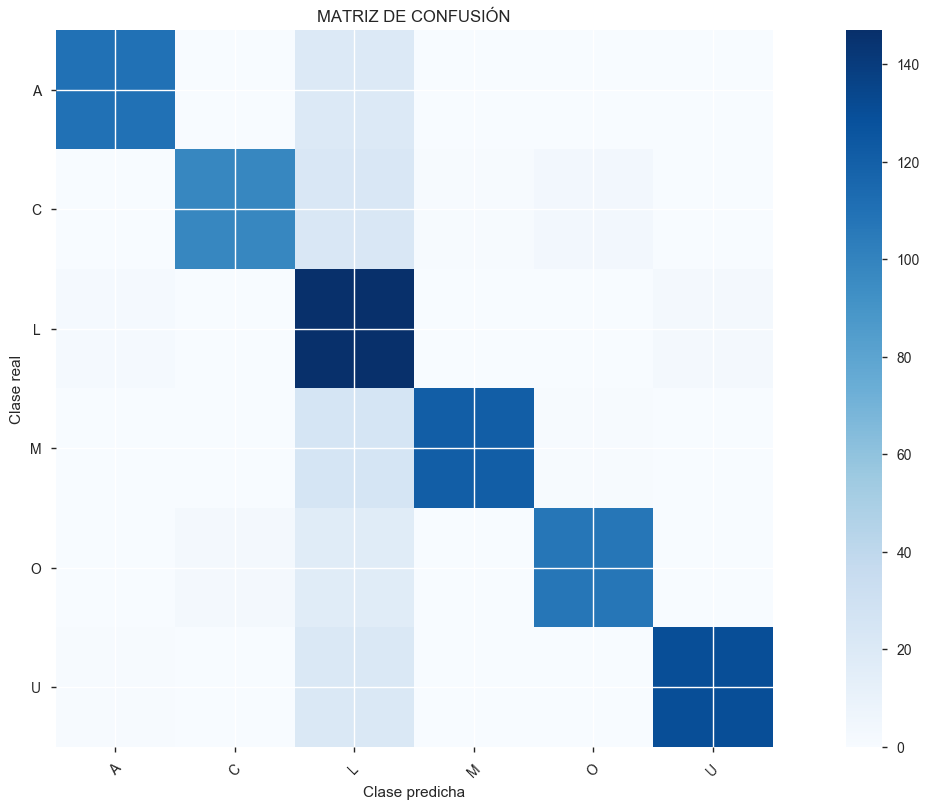

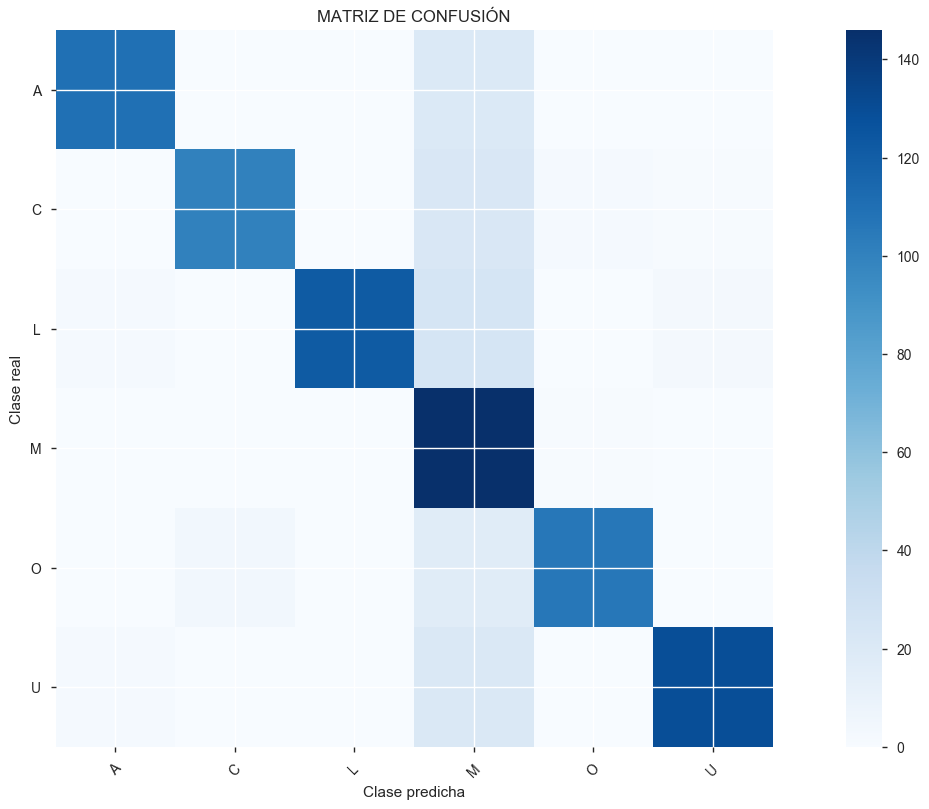

In [164]:
print("############# 10 estimator ################")
excercise_1(all_data_1S, 10)
print("############# 15 estimator ################")
excercise_1(all_data_1S, 15)
print("############# 20 estimator ################")
excercise_1(all_data_1S, 20)
print("############# 30 estimator ################")
excercise_1(all_data_1S, 30)
print("############# 50 estimator ################")
excercise_1(all_data_1S, 50)
print("############# 10 estimator ################")
excercise_1(all_data_1S, 100)

## Correr dataset de la mano izquierda sin augmentation

In [170]:
# carga dataset
data_izq = pd.DataFrame()
data = pd.DataFrame()
all_features_1S = pd.DataFrame()

path = 'dataset-proyecto/test_izq/' #enter thepath for the dataset folder
header_path = 'header-proy.csv' #enter the path for the header file
header=pd.read_csv(header_path,names=['column',''],sep=';', decimal=',')['column'].values
num_letters = range(1,7) #7

for num_letter in num_letters:
    letter = num_to_letter(num_letter)
    try:
        file_name = path+str(letter)+'-'+str(6)+'-'+str(1)+'.csv'
        print(str(letter)+'-'+str(6)+'-'+str(1)+'.csv')
        data, labels = read(file_name, header, num_letter, trial)
        data['fecha'] = pd.to_datetime(data['fecha'], format='%H.%M.%S.%f', errors='ignore')
        data.loc[:,'MILLISEC':] = data.loc[:,'MILLISEC':].apply(pd.to_numeric, errors='coerce')
        all_features_1S = windowing(data, 1000, '1S', 500, labels, 58)
        data_izq = pd.concat([data_izq, all_features_1S])
    except:
        print("Error cargando el archivo : "+ str(letter)+'-'+str(6)+'-'+str(1)+'.csv')
            


A-6-1.csv


/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


C-6-1.csv
L-6-1.csv
M-6-1.csv
O-6-1.csv
U-6-1.csv


############# Mano izquierda en datos de entrenamiento mano derecha ################
X_train: (2524, 90)
X_test: (246, 90)
y_train: (2524,)
y_test: (246,)

 _______________________________________________________
confusion matrix: 

[[ 0  0  0 46  0  0]
 [ 0  0  0 36  0  0]
 [ 0  0  0 36  0  0]
 [ 0  0  0 46  0  0]
 [ 0  0  0 32  0  0]
 [48  0  0  2  0  0]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        46
         2.0       0.00      0.00      0.00        36
         3.0       0.00      0.00      0.00        36
         4.0       0.23      1.00      0.38        46
         5.0       0.00      0.00      0.00        32
         6.0       0.00      0.00      0.00        50

   micro avg       0.19      0.19      0.19       246
   macro avg       0.04      0.17      0.06       246
weighted avg       0.04      0.19      0.07       246

______________

/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


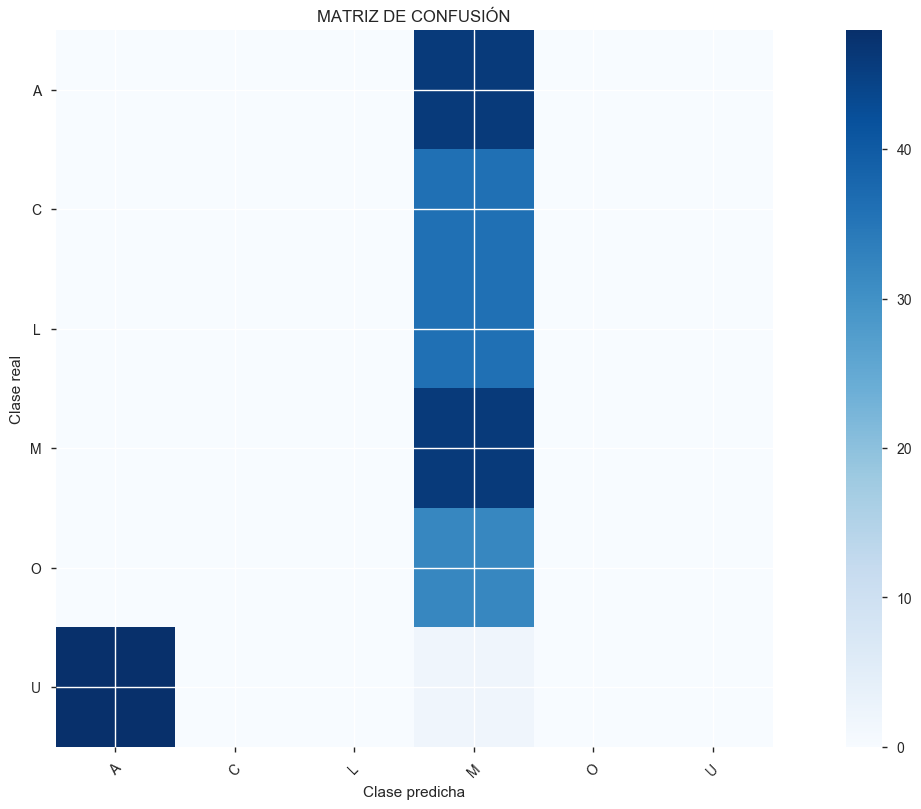

In [231]:
print("############# Mano izquierda en datos de entrenamiento mano derecha ################")
excercise_2(all_data_1S, data_izq, 30)